In [12]:
from dataclasses import dataclass

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

from project.post_processing import Plotter
from project.gen_data import gen_data
from project.timer import Timer
from project.metric import *

from heat import HeatConstParam, solve_analytical_and_numerical, plot_analytical_and_numerical

TIMER_REPEAT_TIMES = 25

@dataclass
class MLPParam:
    activation = 'relu'
    hidden_layer_sizes = (150, 200, 150, 150)

    def __str__(self) -> str:
        rs = "MLP Param: \n"
        rs =  rs + "activation: {}\n".format(self.activation)
        rs =  rs + "hidden_layer_sizes: {}\n".format(self.hidden_layer_sizes)
        return rs

def train_mlp(regr, X_train, y_train):
    # Train
    ti = Timer()
    ti.start()
    regr.fit(X_train, y_train)
    ti.stop()
    print("Training time: "+ ti.str_elapsed_time())


heat_1d_boundary_sin_exact: Average time with 25 tries: 0.0004 seconds
finite_difference_crank_nicolson: Average time with 25 tries: 0.0074 seconds


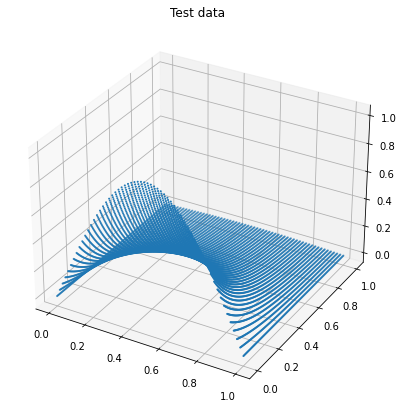

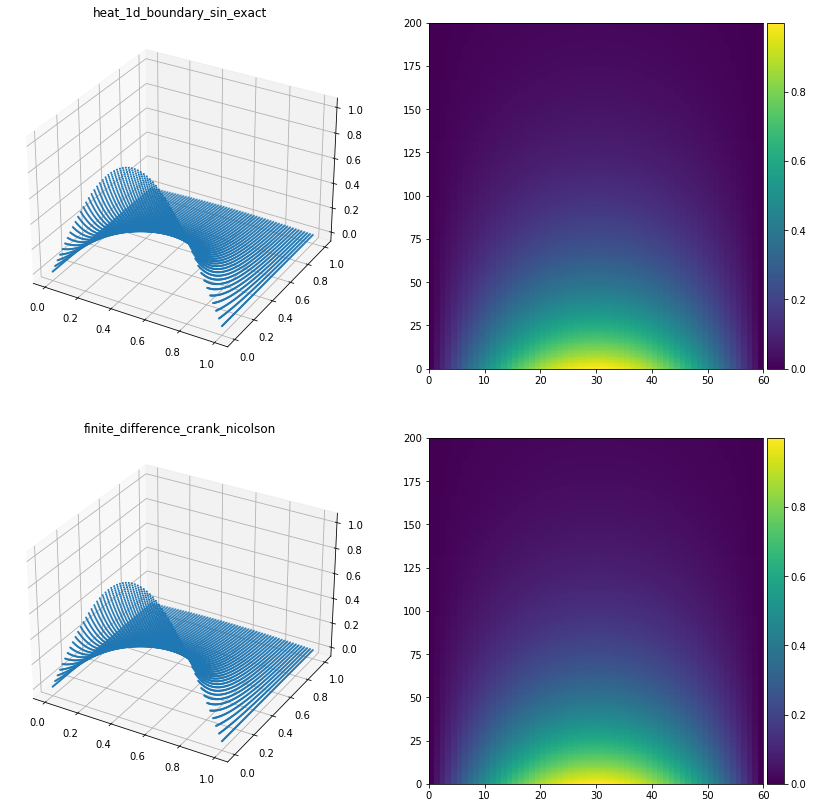

In [14]:
# Generate const test data
const_params = HeatConstParam()
solve_analytical_and_numerical(const_params, timer_repeat_times=TIMER_REPEAT_TIMES)

Plotter(1,1).plot_2d_y(const_params.X_test, const_params.y_analytical, "Test data")
plot_analytical_and_numerical(Plotter(2,2), const_params)


## Train and Prediction speed of traditional NN


In [15]:
mlp_params = MLPParam()

regr = MLPRegressor(hidden_layer_sizes = mlp_params.hidden_layer_sizes, activation=mlp_params.activation, tol=1e-3)
train_mlp(regr, const_params.X_test, const_params.y_analytical)

ti = Timer(TIMER_REPEAT_TIMES)
y_predict = ti.time_average(lambda: regr.predict(const_params.X_test))
print("Predict time: "+ ti.str_average())
output_performance(const_params.y_analytical, y_predict)

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 2.1901 seconds
Predict time: Average time with 25 tries: 0.0503 seconds
Mean absolute error:  0.0018939619283234986
Mean squared error:  6.29513906784698e-06
Max error:  0.01698607882559635


## If I only have the early time points of my solution, can the NN predict it?

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 0.5451 seconds


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 0.9903 seconds


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 1.4226 seconds


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 1.9410 seconds


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 2.3225 seconds
[0.12559844044791313, 0.029196872159023484, 0.006422485119457761, 0.006557076279492162, 0.0020454621377137203]


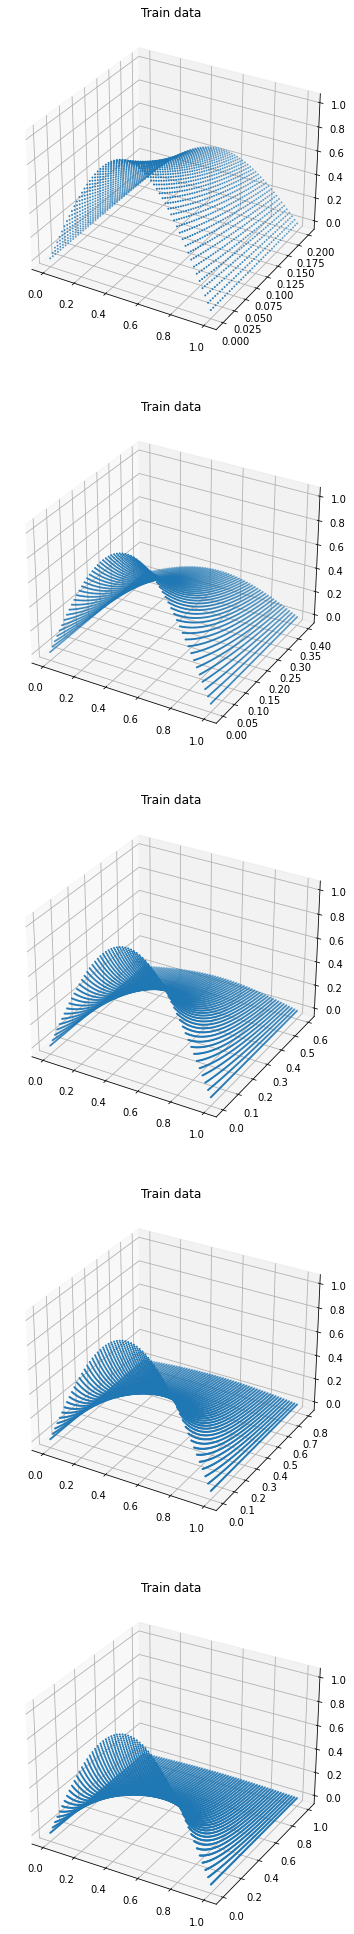

In [16]:
# Make sure it divides well with test_t_dim and t_end
t_data_cutoffs = [0.2, 0.4, 0.6, 0.8, 1.0]
models = []
maes = []
mlp_params = MLPParam()

def create_data_and_model(const_params: HeatConstParam, mlp_params:MLPParam, t_data_cutoff = 1.0):
    data_dict = {
        "x_range": (0, const_params.L),
        "t_range": (0, float(const_params.t_end * t_data_cutoff)),
        "x_dim": const_params.test_x_dim,
        "t_dim": int(const_params.test_t_dim * t_data_cutoff),
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    }
    X_train, y_train = gen_data("heat_1d_boundary_sin_exact", data_dict)
    regr = MLPRegressor(hidden_layer_sizes = mlp_params.hidden_layer_sizes, activation=mlp_params.activation, tol=1e-3)
    return X_train, y_train, regr

plotter = Plotter(len(t_data_cutoffs), 1)
for t_data_cutoff in t_data_cutoffs:
    X_train, y_train, regr = create_data_and_model(const_params, mlp_params, t_data_cutoff = t_data_cutoff)
    plotter.plot_2d_y(X_train, y_train, "Train data")
    train_mlp(regr, X_train, y_train)
    ti = Timer(TIMER_REPEAT_TIMES)
    y_predict = ti.time_average(lambda: regr.predict(const_params.X_test))
    mae =  compute_mean_abs_error(const_params.y_analytical, y_predict.reshape(-1,1))
    models.append(regr)
    maes.append(mae)

print(maes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---t_cuttoff 0.2---
mae:  0.12559844044791313
Mean absolute error:  0.12559844044791313
Mean squared error:  0.022854914402338892
Max error:  0.273525158020256
NN prediction, t_cutoff 0.2, prediction time: Average time with 10 tries: 0.0496 seconds
---t_cuttoff 0.4---
mae:  0.029196872159023484
Mean absolute error:  0.029196872159023484
Mean squared error:  0.0018329286716237778
Max error:  0.12418709575658818
NN prediction, t_cutoff 0.4, prediction time: Average time with 10 tries: 0.0503 seconds
---t_cuttoff 0.6---
mae:  0.006422485119457761
Mean absolute error:  0.006422485119457761
Mean squared error:  0.00012664357728261848
Max error:  0.049001959171693144
NN prediction, t_cutoff 0.6, prediction time: Average time with 10 tries: 0.0507 seconds
---t_cuttoff 0.8---
mae:  0.006557076279492162
Mean absolute error:  0.006557076279492162
Mean squared error:  8.189312457032263e-05
Max error:  0.036670271973618176
NN prediction, t_cutoff 0.8, prediction time: Average time with 10 tries: 0

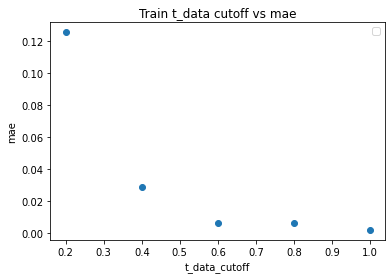

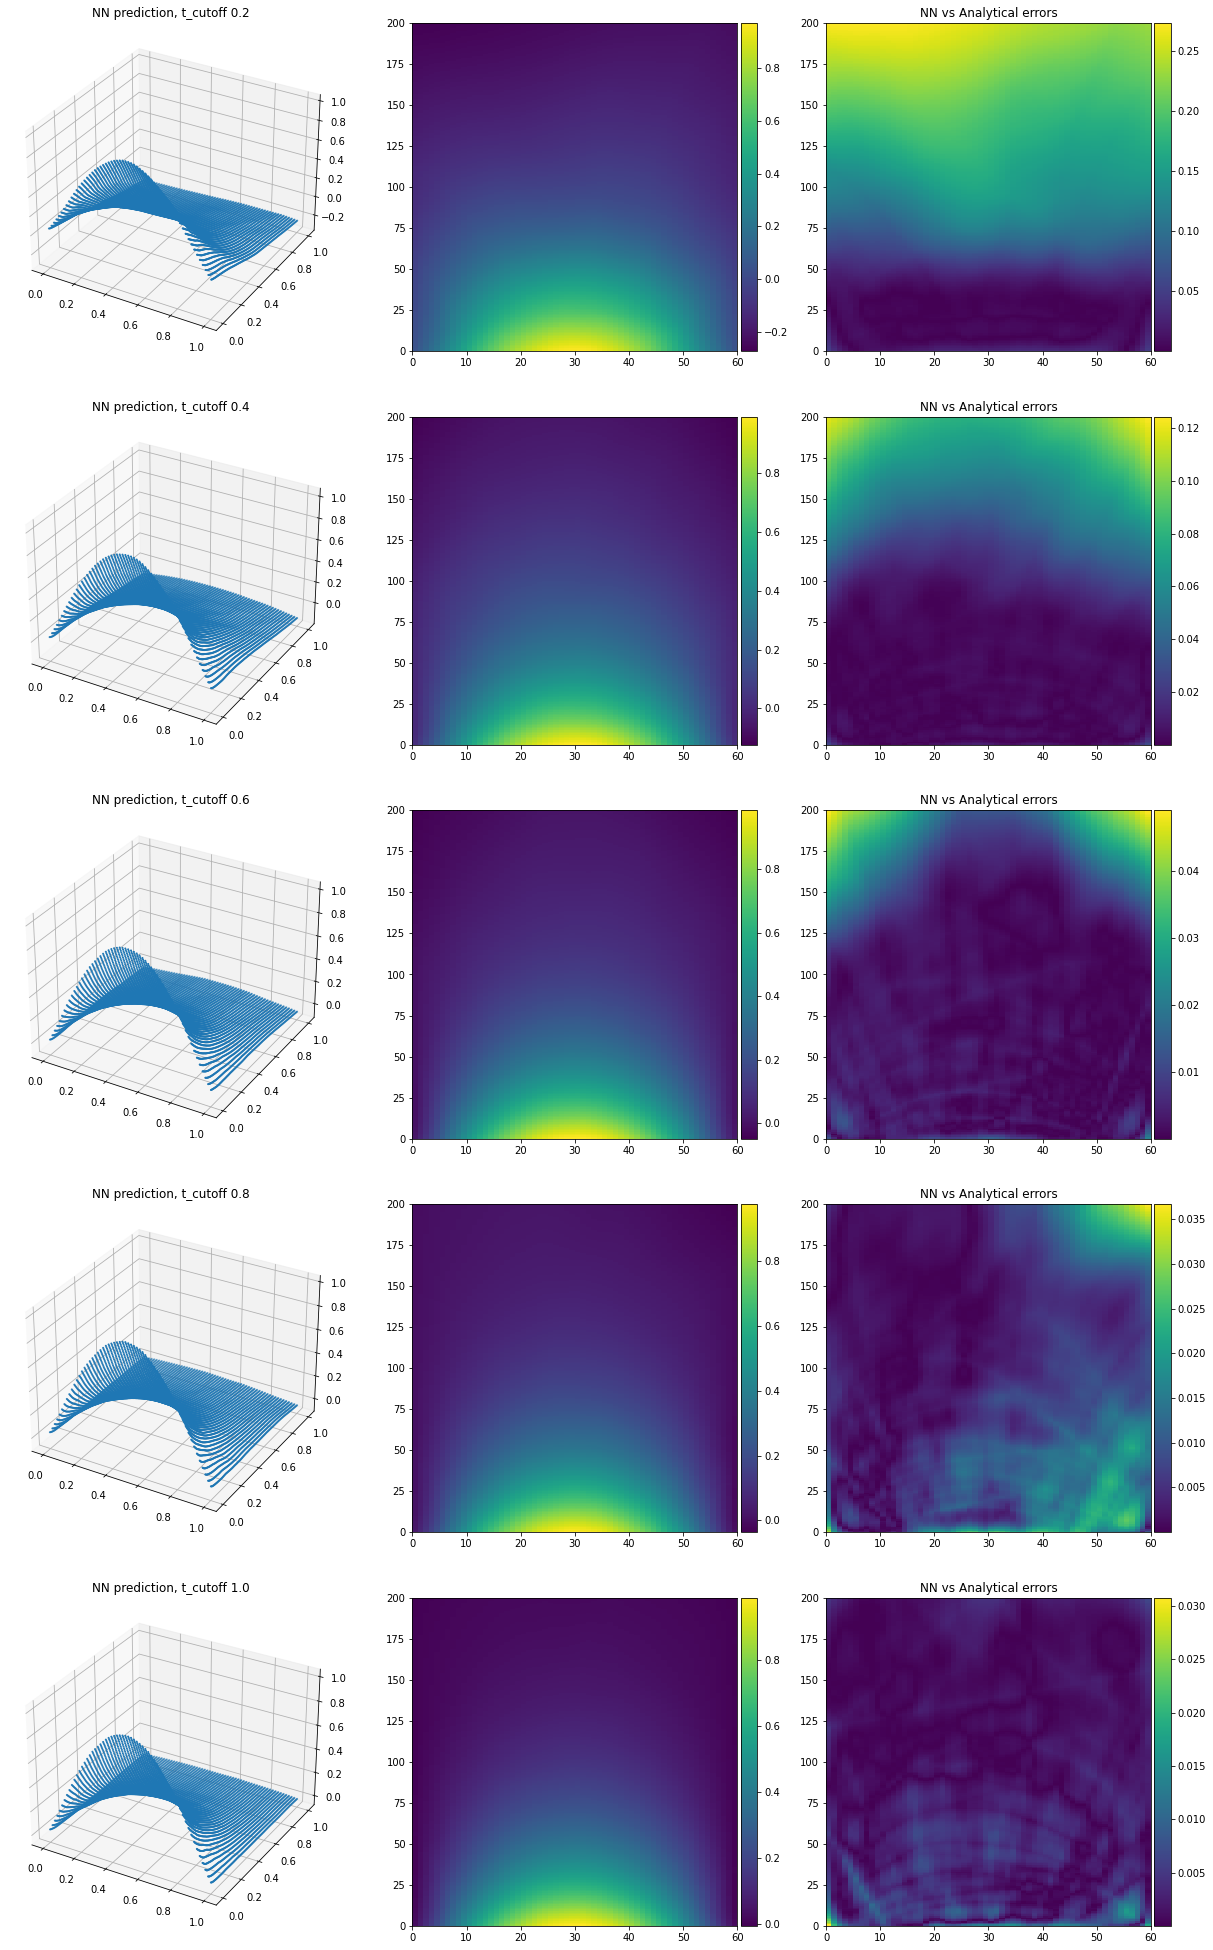

In [17]:
import matplotlib.pyplot as plt

def plot_line(x, y):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x, y)
    ax.legend()
    ax.set_xlabel("t_data_cutoff")
    ax.set_ylabel("mae")
    ax.title.set_text("Train t_data cutoff vs mae")

plot_line(t_data_cutoffs, maes)

plotter = Plotter(len(t_data_cutoffs), 3)
for i in range(len(models)):
    model = models[i]
    t_cutoff = t_data_cutoffs[i]
    print("---t_cuttoff {}---".format(t_cutoff))
    print("mae: ", maes[i])

    # Copied
    function_name = "NN prediction, t_cutoff {}".format(t_cutoff)
    ti = Timer()
    y_pred = ti.time_average(lambda : model.predict(const_params.X_test))
    y_pred = y_pred.reshape(-1, 1)
    output_performance(const_params.y_analytical, y_pred)
    print(function_name + ", prediction time: "+ ti.str_average())
    plotter.plot_2d_y(const_params.X_test, y_pred, function_name)
    plotter.plot_2d_colormesh(
        y_pred,
        const_params.test_x_dim,
        const_params.test_t_dim)
    #
    pinn_analytical_errors = compute_errors(const_params.y_analytical, y_pred)
    plotter.plot_2d_colormesh(
        pinn_analytical_errors,
        const_params.test_x_dim,
        const_params.test_t_dim,
        "NN vs Analytical errors")
    # Copied

Training time: Elapsed time: 0.0464 seconds
Training time: Elapsed time: 0.0681 seconds
Training time: Elapsed time: 0.1615 seconds
Training time: Elapsed time: 0.2958 seconds
Training time: Elapsed time: 0.4361 seconds
Training time: Elapsed time: 0.8458 seconds
Training time: Elapsed time: 1.1653 seconds


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 2.1029 seconds
maes [0.07423019942716509, 0.042217716592323457, 0.018814589270903372, 0.009161334881479797, 0.004618634023693241, 0.004666454599478109, 0.004278932522339431, 0.00274037549816734]


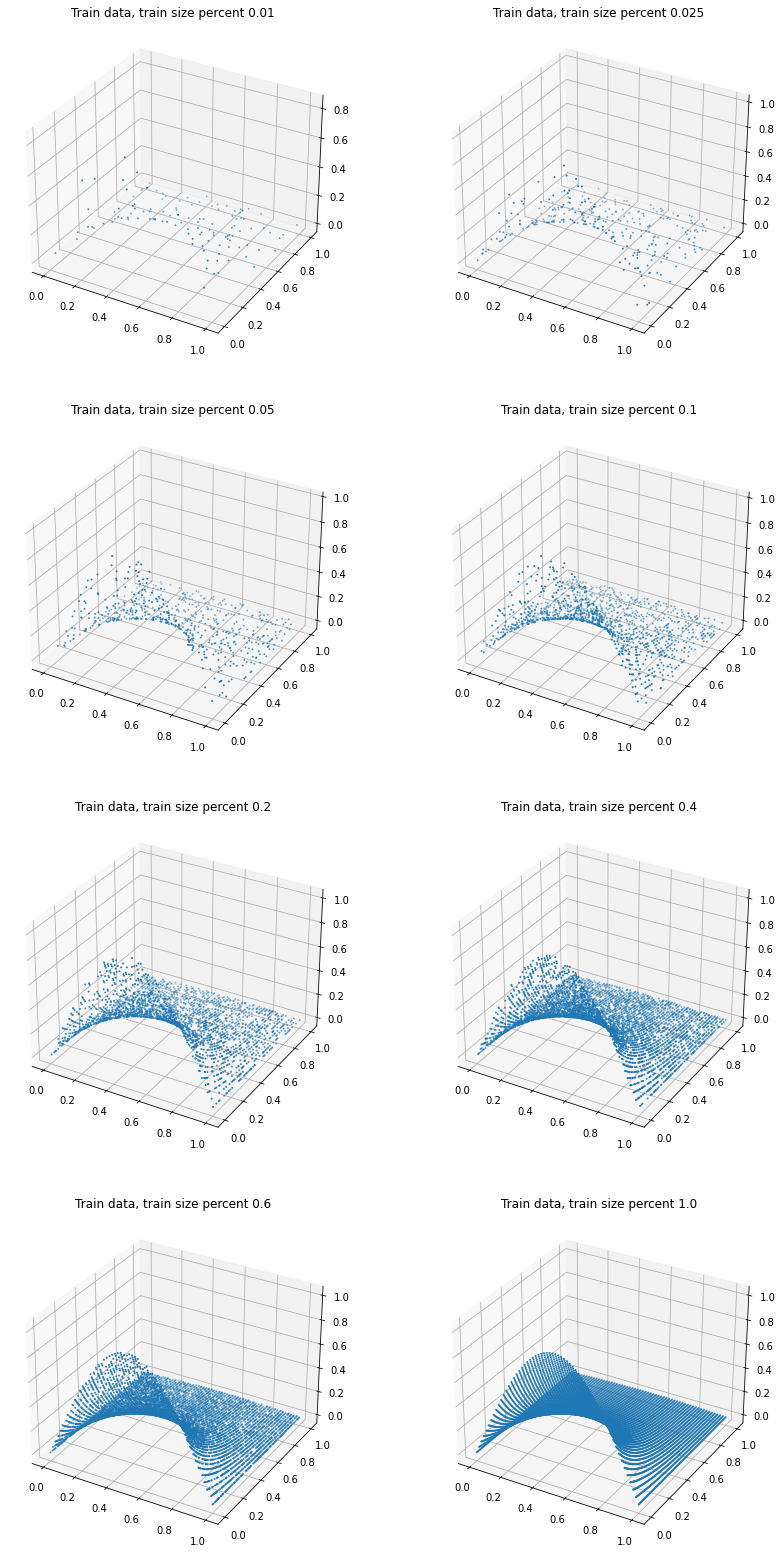

In [19]:
# Make sure it divides well with test_t_dim and t_end
train_size_percents = [0.01, 0.025, 0.05, 0.1, 0.2, 0.4, 0.6, 1.0]
models = []
maes = []
mlp_params = MLPParam()

plotter = Plotter(int(len(train_size_percents)/2), 2)
for train_size in train_size_percents:
    if train_size != 1:
        X_train, _ , y_train, _ = train_test_split(const_params.X_test, const_params.y_analytical.flatten(), train_size = train_size)
    else:
        X_train = const_params.X_test
        y_train = const_params.y_analytical
    regr = MLPRegressor(hidden_layer_sizes = mlp_params.hidden_layer_sizes, activation=mlp_params.activation, tol=1e-3)

    plotter.plot_2d_y(X_train, y_train.reshape(-1, 1), "Train data, train size percent {}".format(train_size))
    train_mlp(regr, X_train, y_train)
    y_predict = regr.predict(const_params.X_test)
    mae =  compute_mean_abs_error(const_params.y_analytical, y_predict.reshape(-1,1))
    models.append(regr)
    maes.append(mae)

print("maes", maes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


train size total:  12000
-----
mae:  0.07423019942716509
train_size_percent:  0.01
Mean absolute error:  0.07423019942716509
Mean squared error:  0.014213032302424523
Max error:  0.5552111287693823
NN prediction, train_size_percent 0.01, prediction time: Average time with 10 tries: 0.0496 seconds
-----
mae:  0.042217716592323457
train_size_percent:  0.025
Mean absolute error:  0.042217716592323457
Mean squared error:  0.004511162683030064
Max error:  0.36915165537930283
NN prediction, train_size_percent 0.025, prediction time: Average time with 10 tries: 0.0472 seconds
-----
mae:  0.018814589270903372
train_size_percent:  0.05
Mean absolute error:  0.018814589270903372
Mean squared error:  0.0007590810098200788
Max error:  0.2099540094333967
NN prediction, train_size_percent 0.05, prediction time: Average time with 10 tries: 0.0505 seconds
-----
mae:  0.009161334881479797
train_size_percent:  0.1
Mean absolute error:  0.009161334881479797
Mean squared error:  0.0002460148566274263
Max 

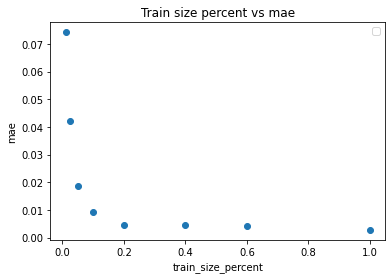

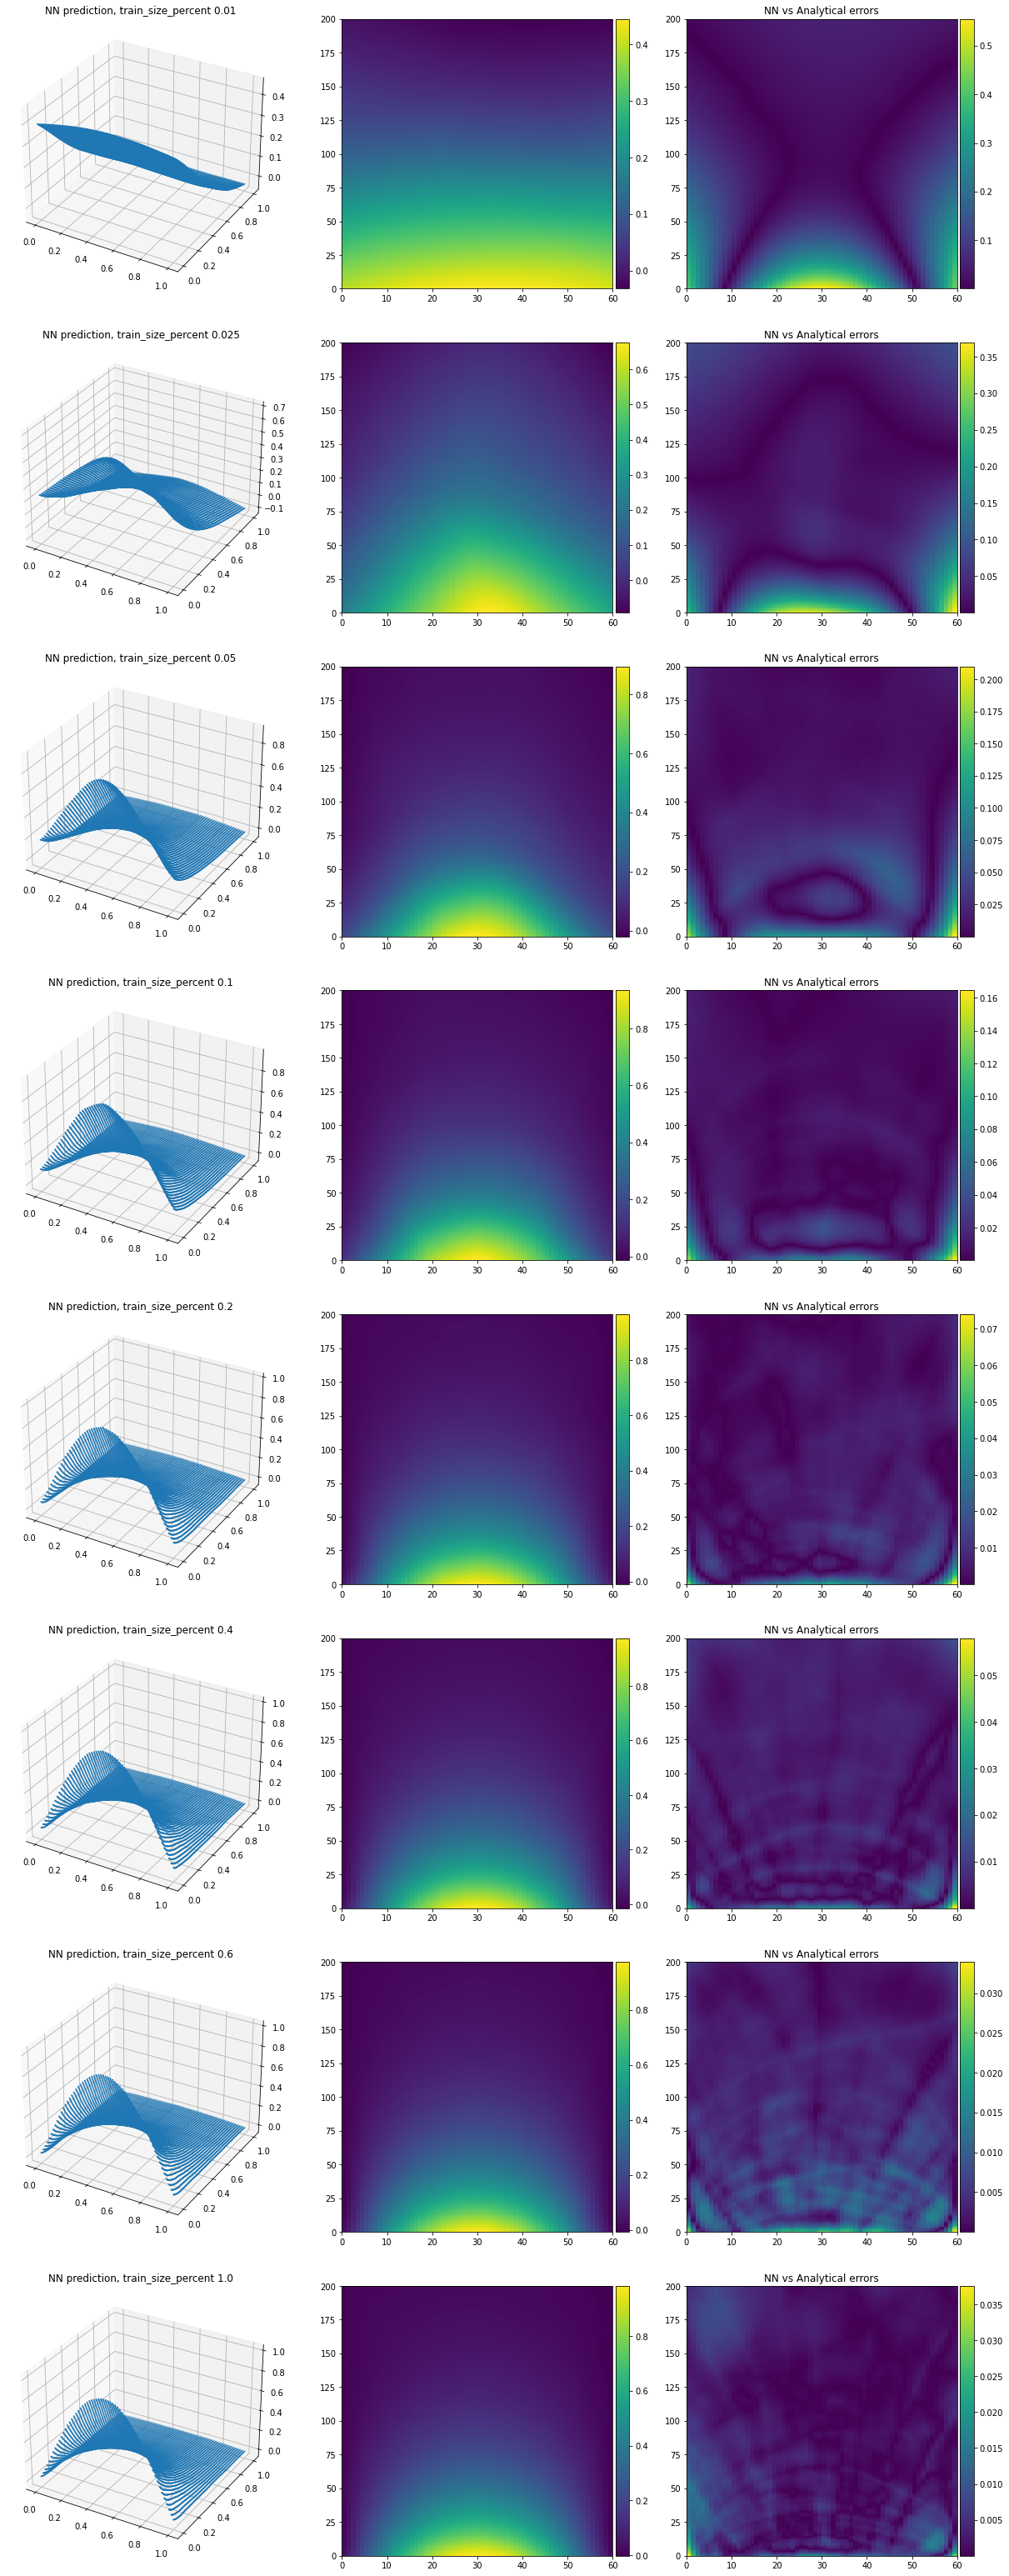

In [20]:
import matplotlib.pyplot as plt

def plot_line(x, y):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x, y)
    ax.legend()
    ax.set_xlabel("train_size_percent")
    ax.set_ylabel("mae")
    ax.title.set_text("Train size percent vs mae")

print("train size total: ", const_params.y_analytical.shape[0])
plot_line(train_size_percents, maes)

plotter = Plotter(len(train_size_percents), 3)
for i in range(len(models)):
    model = models[i]
    print("-----")
    train_size_percent = train_size_percents[i]
    print("mae: ", maes[i])
    print("train_size_percent: ", train_size_percent)

    # Copied
    function_name = "NN prediction, train_size_percent {}".format(train_size_percent)
    ti = Timer()
    y_pred = ti.time_average(lambda : model.predict(const_params.X_test))
    y_pred = y_pred.reshape(-1, 1)
    output_performance(const_params.y_analytical, y_pred)
    print(function_name + ", prediction time: "+ ti.str_average())
    plotter.plot_2d_y(const_params.X_test, y_pred, function_name)
    plotter.plot_2d_colormesh(
        y_pred,
        const_params.test_x_dim,
        const_params.test_t_dim)
    #
    pinn_analytical_errors = compute_errors(const_params.y_analytical, y_pred)
    plotter.plot_2d_colormesh(
        pinn_analytical_errors,
        const_params.test_x_dim,
        const_params.test_t_dim,
        "NN vs Analytical errors")
    # Copied